#  Обсчёт АБ-теста

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
from statsmodels.sandbox.stats.multicomp import multipletests 

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

Давайте представим, что у нас с вами есть сервис, который работает по подписке (онлайн игра, стриминговый сервис, например). Один из важных факторов успешности бизнеса в таком случае - это удержание пользователей, нам надо придумать, как заинтересовать пользователя в продлении подпсики. Возникла идея дать скидку в $1\%$ на продление подписки. Чтобы оценить эфект от этой идеи мы как-то разбили пользователей, которые купили подписку за период теста, на две группы и одним дали скидку на продление, а другим нет.

In [2]:
df1 = pd.read_csv('data/subscribers_1.csv', sep=',')
print(df1.shape)
df1.head()

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,1
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,1
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `rn` - порядковый номер покупки подписки за период.  
* `last_duration_days` - длительность предыдущей подписки.
* `new_duration_days` - длительность текущей подписки.
* `is_same` - менялась ли длительность подписки.
* `group` - группа теста, в которую попал пользователь. 1 - тест, 0 - контроль.

__а)__ Обсчитайте результаты АБ-теста. Найдите разницу между старой и новой длительностями подписки. Постройте для этой разницы гистограмму.

In [3]:
# your code here

# Рассчитаем разность между старой и новой длительностями подписки
df1['duration_diff'] = df1.new_duration_days - df1.last_duration_days
df1.groupby('group').duration_diff.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
0,12791.0,2.139004,15.686722,-90.0,0.0,0.0,0.0,150.0
1,13144.0,1.994827,15.361171,-150.0,0.0,0.0,0.0,150.0


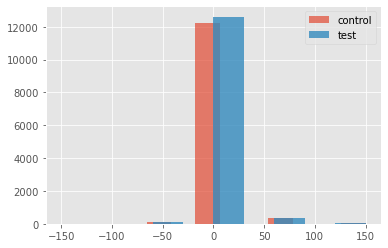

In [4]:
# Посмотрим на распределения для каждой группы
plt.hist(df1[df1.group == 0].duration_diff, alpha=0.7, label='control')
plt.hist(df1[df1.group == 1].duration_diff, alpha=0.8, label='test')
plt.legend();

Правда ли, что средняя длительность подписки изменилась на $1\%$ уровне значимости? Для ответа на этот вопрос воспользуйтесь асимптотическим тестом на равенство средних против двусторонней альтернативы. Сохраните в переменную `z_obs` получившееся значение статистики, а в `pvalue` получившееся $p$-значение.

In [5]:
# your code here
alpha = 0.01

x = df1[df1.group == 0].duration_diff.values
y = df1[df1.group == 1].duration_diff.values

nx, ny = x.size, y.size

diff = x.mean() - y.mean()
diff_std = np.sqrt(x.var(ddof=1) / nx + y.var(ddof=1) / ny)

z_obs = diff/diff_std
z_crit = sts.norm.ppf(1 - alpha/2)

pvalue = 2 * (1 - sts.norm().cdf(z_obs))
print(f'Наблюдаемое значение {z_obs:.4} меньше критического {z_crit:.4}. P-value: {pvalue:.4}')

Наблюдаемое значение 0.7476 меньше критического 2.576. P-value: 0.4547


__б)__ А теперь представим, что мы продвинутые АБ-тестеры и решили провести ААБ тест (2 контрольные группы и одну тестовую).

In [6]:
df2 = pd.read_csv('data/subscribers_2.csv', sep=',')
print(df2.shape)
df2.head()

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,new_group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,2
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,2
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `new_group` - группа теста, в которую попал пользователь. $2$ - тест, $0,1$ - контроль.

Проверьте гипотезу о том, что в каждой из контрольных групп среднее совпадает с тестовой на уровне значимости $1\%$. Получившиеся $p$-значения запишите в переменные `pval_1` и `pval_2`. Сделайте корректировку методом Холма. Запишите количество отвергнутых гипотез в переменную `hyp_cnt`. 

In [7]:
df2['duration_diff'] = df2.new_duration_days - df2.last_duration_days
df2.groupby('new_group').duration_diff.describe()

,count,mean,std,min,25%,50%,75%,max
new_group,,,,,,,,
0,8509.0,2.023740,14.845036,-150.0,0.0,0.0,0.0,150.0
1,8595.0,1.968586,15.803996,-90.0,0.0,0.0,0.0,150.0
2,8831.0,2.201336,15.881091,-60.0,0.0,0.0,0.0,150.0


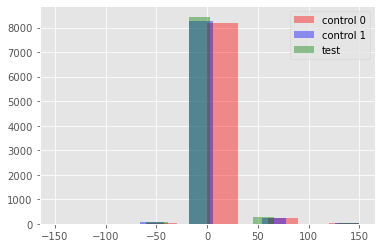

In [8]:
plt.hist(df2[df2.new_group == 0].duration_diff, alpha=0.4, label='control 0', color='r')
plt.hist(df2[df2.new_group == 1].duration_diff, alpha=0.4, label='control 1', color='b')
plt.hist(df2[df2.new_group == 2].duration_diff, alpha=0.4, label='test', color='g')
plt.legend();

In [9]:
# your code here
x = df2[df2.new_group == 2].duration_diff.values
y = df2[df2.new_group == 0].duration_diff.values
z = df2[df2.new_group == 1].duration_diff.values

nx, ny, nz = x.size, y.size, z.size

diff1 = x.mean() - y.mean()
diff_std1 = np.sqrt(x.var(ddof=1) / nx + y.var(ddof=1) / ny)

z_obs1 = diff1/diff_std1
pval_1 = 2 * (1 - sts.norm().cdf(z_obs1))


diff2 = x.mean() - z.mean()
diff_std2 = np.sqrt(x.var(ddof=1) / nx + z.var(ddof=1) / nz)

z_obs2= diff2/diff_std2
pval_2 = 2 * (1 - sts.norm().cdf(z_obs2))


rejected, p_corrected, _, _ = multipletests([pval_1, pval_2], alpha = 0.01, method = 'holm')
hyp_cnt = (p_corrected < 0.01).sum()

print(f'Корректированные значения p-value: {p_corrected}')
print(f'Кол-во отвергнутых гипотез {hyp_cnt}')

Корректированные значения p-value: [0.66446093 0.66446093]
Кол-во отвергнутых гипотез 0


<br>